# Import packages

In [155]:
import os
import cv2 
import numpy as np
import mediapipe as mp
import time
from tensorflow import keras
import tensorflow
# import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
mp_holistic = mp.solutions.holistic # Holistic model to detect keypoints
mp_drawing = mp.solutions.drawing_utils # Drawing utilities)
print(keras.__version__)
# print(keras2.__version__)

2.10.0


# Testing Holistic model with opencv (not required for model training)

In [2]:
FPS = 30
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hoslistic:
    while cap.isOpened():
        start = time.time()
        success, frame = cap.read()
        if not success: # if capture frame failed then skip the logic below and retry
            continue

        # Copy frame
        img = frame.copy()
        img = cv2.flip(img, 1)
        img = cv2.cvtColor(cv2.flip(img,1),cv2.COLOR_BGR2RGB) # Set frame color to RGB to process
        # img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        # input_img = tf.cast(img, dtype=tf.int32)
        img.flags.writeable = False
        # Detection section
        results = hoslistic.process(img)
        if results.left_hand_landmarks:
            print(results.left_hand_landmarks)
        img.flags.writeable = True
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # set back to original color
        # draw keypoints to the frame
        mp_drawing.draw_landmarks(img,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(img,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(img,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
        # Render keypoints 
        # loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
        # end = time.time()
        # totaltime = end-start
        # fps = 1/totaltime
        # cv2.putText(img,f'FPS: {int(fps)}',(20,70),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2,cv2.LINE_AA,False)
        cv2.imshow('Testing Holistic Model', img)
         #This breaks on 'q' key
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
print("HERE")
cap.release()
cv2.destroyAllWindows()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


KeyboardInterrupt: 

: 

In [34]:
# print(new(results.__new__))

In [18]:
# print last frame landmarks
print(results.pose_landmarks)
print(results.left_hand_landmarks)
print(results.right_hand_landmarks)

landmark {
  x: 0.4264903664588928
  y: 0.48218443989753723
  z: -0.8057156801223755
  visibility: 0.9999212622642517
}
landmark {
  x: 0.4678216576576233
  y: 0.3988126516342163
  z: -0.7541573643684387
  visibility: 0.9998189210891724
}
landmark {
  x: 0.492043673992157
  y: 0.39854589104652405
  z: -0.7538420557975769
  visibility: 0.9997694492340088
}
landmark {
  x: 0.5114008784294128
  y: 0.39861324429512024
  z: -0.7539421916007996
  visibility: 0.9997957944869995
}
landmark {
  x: 0.41107597947120667
  y: 0.4000115692615509
  z: -0.7278512120246887
  visibility: 0.9998339414596558
}
landmark {
  x: 0.3951709270477295
  y: 0.4018693268299103
  z: -0.7269402742385864
  visibility: 0.9998106360435486
}
landmark {
  x: 0.3797028362751007
  y: 0.4051903486251831
  z: -0.7271029949188232
  visibility: 0.9998696446418762
}
landmark {
  x: 0.5456597805023193
  y: 0.4481964409351349
  z: -0.4252781271934509
  visibility: 0.9998052716255188
}
landmark {
  x: 0.3744216561317444
  y: 0.450

In [29]:
# double check the landmarks length
print(f'Length of pose landmarks: {len(results.pose_landmarks.landmark)}')
# print(f'Length of left hand landmarks: {len(results.left_hand_landmarks.landmark)}') # it will return null if no hand detected
# print(f'Length of right hand landmarks: {len(results.right_hand_landmarks.landmark)}')

Length of pose landmarks: 33


### Extract keypoints values to array


In [82]:
# there should be 33 pose(x,y,z,visibility), 21(x,y,z) left hand and 21(x,y,z) right hand landmarks
# order should be pose -> left -> right
landmarks = np.empty(33*4+21*3+21*3)
print(f'size should be {len(landmarks)}')

size should be 258


### Extract pose landmarks

In [81]:
pose_landmarks = np.array([[l.x,l.y,l.z,l.visibility] for l in results.pose_landmarks.landmark])
print(pose_landmarks.shape)
print(f'length of pose landmarks {len(pose_landmarks)}')
print(f'flattern length of pose landmarks {len(pose_landmarks.flatten())}')



(33, 4)
length of pose landmarks 33
flattern length of pose landmarks 132
(258,)


### Extract left hand landmarks

In [90]:
lefthand_landmarks = np.array([[l.x,l.y,l.z] for l in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros(21*3)
print(f'length of left hand landmarks {len(lefthand_landmarks)}')
print(f'flattern length of left hand landmarks {len(lefthand_landmarks.flatten())}')

length of left hand landmarks 63
flattern length of left hand landmarks 63


### Extract right hand landmarks

In [91]:
righthand_landmarks = np.array([[l.x,l.y,l.z] for l in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros(21*3)
print(f'length of right hand landmarks {len(righthand_landmarks)}')
print(f'flattern length of right hand landmarks {len(righthand_landmarks.flatten())}')


length of right hand landmarks 21
flattern length of right hand landmarks 63


### Append to the main landmarks array

In [92]:
landmarks = np.concatenate([pose_landmarks.flatten(),lefthand_landmarks.flatten(),righthand_landmarks.flatten()])
landmarks.shape

(258,)

### Put it into a function

In [2]:
def keypointsToNumPy(results):
    pose_landmarks = np.array([[l.x,l.y,l.z,l.visibility] for l in results.pose_landmarks.landmark])
    lefthand_landmarks = np.array([[l.x,l.y,l.z] for l in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks and len(results.left_hand_landmarks.landmark)>0 else np.zeros(21*3)
    righthand_landmarks = np.array([[l.x,l.y,l.z] for l in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks and len(results.right_hand_landmarks.landmark)>0 else np.zeros(21*3)
    landmarks = np.concatenate([pose_landmarks.flatten(),lefthand_landmarks.flatten(),righthand_landmarks.flatten()])
    return landmarks

In [56]:
# test function
keypointsToNumPy(results).shape

(258,)

# Define key points to numpy function

In [110]:
def keypointsToNumPy(results):
    pose_landmarks = np.array([[l.x,l.y,l.z,l.visibility] for l in results.pose_landmarks.landmark])
    lefthand_landmarks = np.array([[l.x,l.y,l.z] for l in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks and len(results.left_hand_landmarks.landmark)>0 else np.zeros(21*3)
    righthand_landmarks = np.array([[l.x,l.y,l.z] for l in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks and len(results.right_hand_landmarks.landmark)>0 else np.zeros(21*3)
    landmarks = np.concatenate([pose_landmarks.flatten(),lefthand_landmarks.flatten(),righthand_landmarks.flatten()])
    return landmarks

# Collect some training data (only run it if you need to collect data)

In [84]:
# data path
DATA_PATH = os.path.join("manual_data")
actions = np.array(["action_1","action_2","action_3"])

num_sequence = 20
frame_per_sequence = 30

### create folders

In [85]:
for action in actions:
    for s in range(num_sequence):
        # make folder
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(s+1)))
        except:
            continue


### capture data

In [199]:
from unittest import result


cap = cv2.VideoCapture(0)
start = False
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hoslistic:
    for action in actions:
        for s in range(num_sequence):
            for f in range (frame_per_sequence):
                success, frame = cap.read()
                if not success: # if capture frame failed then skip the logic below and retry
                    continue

                # Copy frame
                img = frame.copy()
                img = cv2.cvtColor(cv2.flip(img,1),cv2.COLOR_BGR2RGB) # Set frame color to RGB to process
                # img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
                # input_img = tf.cast(img, dtype=tf.int32)
                img.flags.writeable = False
                # Detection section
                results = hoslistic.process(img)
                img.flags.writeable = True
                # draw keypoints to the frame
                mp_drawing.draw_landmarks(img,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
                mp_drawing.draw_landmarks(img,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
                mp_drawing.draw_landmarks(img,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
                img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # set back to original color
                if f == 0:
                    ## stop for 2 second
                    cv2.waitKey(2000)
                else:
                    cv2.putText(img,f'Action: {action}, sequence: {s+1}',(20,70),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2,cv2.LINE_AA,False)

                keypoints = keypointsToNumPy(results)
                npy_path = os.path.join(DATA_PATH,action,str(s+1),str(f+1))
                # save keypoints as binary file
                np.save(npy_path,keypoints)
                # save frame as well
                cv2.imwrite(npy_path+".png",img)
                cv2.imshow('collect training data', img)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
print("HERE")
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

# Data preparation

### initialize parameters

In [156]:
actions = np.array(["Left_punch","kiss","no_action","Right_punch","Wakanda"])
augmentations = ["CW Rotate 15","CCW Rotate 15","Left","Right","Zoom In","Zoom Out"]
label_map = {label:idx for idx,label in enumerate(actions)}
label_map

{'Left_punch': 0, 'kiss': 1, 'no_action': 2, 'Right_punch': 3, 'Wakanda': 4}

### read preprocessed data

In [161]:
#use ch data
num_sequence = 60
frame_per_sequence = 30
data,labels = [],[]
for action in actions:
    for s in range(num_sequence):
        frames = []
        for f in range(frame_per_sequence):
            if f % 5 != 0:
                continue
            data_path = os.path.join("ch","Train Data",action,str(s),str(f))+".npy"
            d = np.load(data_path)
            # append each frame to sequence
            # drop face
            # d = np.concatenate([d[:33*4],d[33*4+468*3:]])
            frames.append(d)
        # append all frames in a sequence to data
        data.append(frames)
        # set the label
        labels.append(label_map[action])

for action in actions:
    for s in range(num_sequence):
        frames = []
        for f in range(frame_per_sequence):
            if f % 5 != 0:
                continue
            data_path = os.path.join("ch","Test Data",action,str(s),str(f))+".npy"
            d = np.load(data_path)
            # append each frame to sequence
            # d = np.concatenate([d[:33*4],d[33*4+468*3:]])
            frames.append(d)
        # append all frames in a sequence to data
        data.append(frames)
        # set the label
        labels.append(label_map[action])

# augmentation data
for action in actions:
    for aug in augmentations:
        for s in range(num_sequence):
            frames = []
            for f in range(frame_per_sequence):
                if f % 5 != 0:
                    continue
                data_path = os.path.join("ch","Train Data Augmentation",aug,action,str(s),str(f))+".npy"
                d = np.load(data_path)
                # append each frame to sequence
                # drop face
                # d = np.concatenate([d[:33*4],d[33*4+468*3:]])
                frames.append(d)
            # append all frames in a sequence to data
            data.append(frames)
            # set the label
            labels.append(label_map[action])
for action in actions:
    for aug in augmentations:
        for s in range(num_sequence):
            frames = []
            for f in range(frame_per_sequence):
                if f % 5 != 0:
                    continue
                data_path = os.path.join("ch","Test Data Augmentation",aug,action,str(s),str(f))+".npy"
                d = np.load(data_path)
                # append each frame to sequence
                # drop face
                # d = np.concatenate([d[:33*4],d[33*4+468*3:]])
                frames.append(d)
            # append all frames in a sequence to data
            data.append(frames)
            # set the label
            labels.append(label_map[action])
print(np.array(data).shape)

(4200, 6, 1662)


In [4]:
# data,labels = [],[]
# for action in actions:
#     for s in range(num_sequence):
#         frames = []
#         for f in range(frame_per_sequence):
#             data_path = os.path.join(DATA_PATH,action,str(s+1),str(f+1))+".npy"
#             d = np.load(data_path)
#             # append each frame to sequence
#             frames.append(d)
#         # append all frames in a sequence to data
#         data.append(frames)
#         # set the label
#         labels.append(label_map[action])
# np.array(data).shape


### print data shape

In [162]:
# prepare x and y
X = np.array(data)
y = to_categorical(labels).astype(int)
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.05)
# print train and test shape
print(X_train.shape)
print(X_test.shape)

(3990, 6, 1662)
(210, 6, 1662)


# Try LSTM model

In [163]:
model = Sequential()
# model.add(layers.LSTM(64,return_sequences = True,activation = 'relu',input_shape=(30,258)))
# model.add(layers.LSTM(64,return_sequences = True,activation = 'relu',input_shape=(15,258)))
model.add(layers.LSTM(64,return_sequences = True,activation = 'relu',input_shape=(6,1662)))
model.add(layers.LSTM(128,return_sequences = True,activation = 'relu'))
# return_sequences false as next layer is dense layer
model.add(layers.LSTM(64,return_sequences = False,activation = 'relu'))
model.add(layers.Dense(128,activation = 'relu'))
model.add(layers.Dense(32,activation = 'relu'))
model.add(layers.Dense(actions.shape[0],activation = 'softmax'))

In [164]:
# use tensor board to see the accuracy
model.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer='Adam')

In [165]:
log_dir = os.path.join("logs")
tb_callback = TensorBoard(log_dir=log_dir)

history = model.fit(X_train,Y_train,epochs=30,callbacks=[tb_callback])

Epoch 1/30
125/125 [==============================] - 10s 22ms/step - loss: 1.0547 - categorical_accuracy: 0.4960
Epoch 2/30
125/125 [==============================] - 3s 20ms/step - loss: 0.3932 - categorical_accuracy: 0.8461
Epoch 3/30
125/125 [==============================] - 3s 22ms/step - loss: 0.1105 - categorical_accuracy: 0.9647
Epoch 4/30
125/125 [==============================] - 3s 20ms/step - loss: 0.0663 - categorical_accuracy: 0.9779
Epoch 5/30
125/125 [==============================] - 3s 20ms/step - loss: 0.0541 - categorical_accuracy: 0.9845
Epoch 6/30
125/125 [==============================] - 3s 21ms/step - loss: 0.0847 - categorical_accuracy: 0.9727
Epoch 7/30
125/125 [==============================] - 3s 20ms/step - loss: 0.0316 - categorical_accuracy: 0.9907
Epoch 8/30
125/125 [==============================] - 3s 20ms/step - loss: 0.0151 - categorical_accuracy: 0.9955
Epoch 9/30
125/125 [==============================] - 3s 20ms/step - loss: 0.0185 - categorical

In [166]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 6, 64)             442112    
                                                                 
 lstm_16 (LSTM)              (None, 6, 128)            98816     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_55 (Dense)            (None, 128)               8320      
                                                                 
 dense_56 (Dense)            (None, 32)                4128      
                                                                 
 dense_57 (Dense)            (None, 5)                 165       
                                                                 
Total params: 602,949
Trainable params: 602,949
Non-tr

In [167]:
model.evaluate(X_test, Y_test, verbose=1)

7/7 [==============================] - 1s 8ms/step - loss: 0.0502 - categorical_accuracy: 0.9952


[0.05019490793347359, 0.9952380657196045]

### Try Prediction

In [168]:
yhat = model.predict(X_test)
# get the index with max value (label)
yTrue = np.argmax(Y_test,axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()
print(yTrue)
print(yhat)

7/7 [==============================] - 1s 9ms/step
[2, 3, 1, 3, 0, 3, 0, 4, 3, 4, 3, 0, 1, 0, 1, 4, 4, 1, 1, 4, 1, 1, 3, 1, 4, 2, 3, 0, 3, 0, 3, 3, 3, 0, 2, 0, 0, 3, 1, 1, 4, 3, 0, 4, 3, 1, 4, 2, 0, 1, 4, 3, 0, 0, 2, 0, 0, 4, 3, 3, 1, 4, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 3, 2, 2, 0, 2, 2, 3, 3, 4, 0, 3, 0, 4, 0, 0, 2, 2, 2, 2, 0, 3, 4, 3, 4, 2, 4, 2, 4, 1, 3, 1, 4, 0, 1, 2, 1, 0, 3, 4, 2, 3, 2, 4, 1, 3, 2, 0, 0, 2, 2, 0, 2, 4, 1, 2, 3, 3, 0, 3, 4, 3, 3, 2, 3, 3, 4, 3, 0, 4, 1, 2, 1, 2, 2, 2, 3, 3, 2, 3, 0, 3, 3, 0, 0, 0, 0, 2, 4, 0, 1, 2, 3, 0, 3, 2, 0, 0, 2, 4, 0, 4, 2, 2, 2, 3, 4, 4, 0, 0, 3, 0, 3, 4, 0, 1, 0, 4, 4, 2, 2, 2, 2, 1, 1, 1, 2, 0, 4, 2, 1, 1, 3, 4, 0, 4, 0, 2]
[2, 3, 1, 3, 0, 3, 0, 4, 3, 4, 3, 0, 0, 0, 1, 4, 4, 1, 1, 4, 1, 1, 3, 1, 4, 2, 3, 0, 3, 0, 3, 3, 3, 0, 2, 0, 0, 3, 1, 1, 4, 3, 0, 4, 3, 1, 4, 2, 0, 1, 4, 3, 0, 0, 2, 0, 0, 4, 3, 3, 1, 4, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 3, 2, 2, 0, 2, 2, 3, 3, 4, 0, 3, 0, 4, 0, 0, 2, 2, 2, 2, 0, 3, 4, 3, 4, 2, 4, 2, 4, 1, 3, 1, 4, 0,

In [169]:
confusion_matrix(yTrue,yhat)

array([[50,  0,  0,  0,  0],
       [ 1, 33,  0,  0,  0],
       [ 0,  0, 44,  0,  0],
       [ 0,  0,  0, 46,  0],
       [ 0,  0,  0,  0, 36]])

In [170]:
accuracy_score(yTrue,yhat)

0.9952380952380953

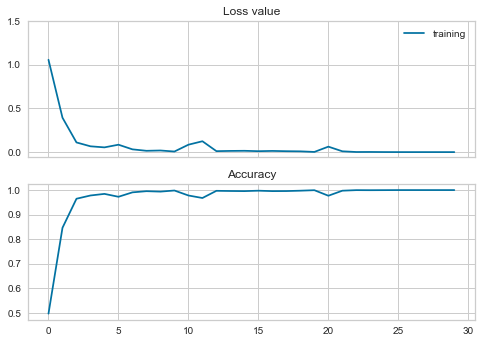

In [173]:
from matplotlib import pyplot as plt
plt.figure()
plt.subplot(211)
# plt.plot(history.history['val_loss'], label="validation")
plt.plot(history.history['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
# plt.plot(history.history['val_categorical_accuracy'],label="validation")
plt.plot(history.history['categorical_accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()


# Save Model

In [174]:
model.save("../models_output/lstm.h5")

In [175]:
model.save_weights("../models_output/lstm_weights.h5")

# Final Test (no need for model training)

In [ ]:
threshold = 0.5
frames = []


cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hoslistic:
    while cap.isOpened():
        success, frame = cap.read()
        if not success: # if capture frame failed then skip the logic below and retry
            continue

        # Copy frame
        img = frame.copy()
        img = cv2.cvtColor(cv2.flip(img,1),cv2.COLOR_BGR2RGB) # Set frame color to RGB to process
        # img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        # input_img = tf.cast(img, dtype=tf.int32)
        img.flags.writeable = False
        # Detection section
        results = hoslistic.process(img)
        img.flags.writeable = True
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # set back to original color
        # draw keypoints to the frame
        mp_drawing.draw_landmarks(img,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(img,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(img,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
        keypoints = keypointsToNumPy(results)
        frames.append(keypoints)
        # just get last 30 frames
        frames = frames[-15:]
        if len(frames) == 15:
            a = np.array(frames)
            # convert it to proper input (1,30,258)
            print(np.expand_dims(frames,axis=0).shape)
            # get the first prediction as we only pass one into it
            r = model.predict(np.expand_dims(frames,axis=0))[0]

            print(actions[np.argmax(r)])
            cv2.putText(img,f'Action {actions[np.argmax(r)]}',(20,70),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2,cv2.LINE_AA,False)
        cv2.imshow('Testing Final Model', img)
         #This breaks on 'q' key
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
print("HERE")
cap.release()
cv2.destroyAllWindows()

(1, 15, 258)
1/1 [==============================] - 0s 23ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 24ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 22ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 22ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 23ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 23ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 20ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 22ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 20ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 20ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 21ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 21ms/step
no_action
(1, 15, 258)
1/1 [==============================] - 0s 22ms/step
no_action
(1, 15, 258)
1/1 [=======

# Try Transformer

In [176]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [177]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    n_classes = len(actions)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [178]:
input_shape = X_train.shape[1:]
print(Y_train.shape)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=2,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.1,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)
# model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    X_train,
    Y_train,
    # validation_split=0.2,
    epochs=30,
    batch_size=40,
    callbacks=callbacks,
    validation_data=(X_test, Y_test)
)

model.evaluate(X_test, Y_test, verbose=1)


(3990, 5)
Epoch 1/30
100/100 [==============================] - 15s 124ms/step - loss: 1.5541 - categorical_accuracy: 0.2336 - val_loss: 1.3358 - val_categorical_accuracy: 0.4000
Epoch 2/30
100/100 [==============================] - 12s 118ms/step - loss: 1.1478 - categorical_accuracy: 0.4223 - val_loss: 0.9084 - val_categorical_accuracy: 0.5190
Epoch 3/30
100/100 [==============================] - 12s 118ms/step - loss: 0.9505 - categorical_accuracy: 0.5090 - val_loss: 0.7931 - val_categorical_accuracy: 0.5571
Epoch 4/30
100/100 [==============================] - 12s 119ms/step - loss: 0.8332 - categorical_accuracy: 0.5674 - val_loss: 0.7296 - val_categorical_accuracy: 0.5524
Epoch 5/30
100/100 [==============================] - 12s 119ms/step - loss: 0.7986 - categorical_accuracy: 0.6030 - val_loss: 0.7359 - val_categorical_accuracy: 0.5762
Epoch 6/30
100/100 [==============================] - 12s 119ms/step - loss: 0.7605 - categorical_accuracy: 0.6206 - val_loss: 0.7418 - val_categ

[0.08944027125835419, 1.0]

In [179]:
model.evaluate(X_test, Y_test, verbose=1)

7/7 [==============================] - 0s 47ms/step - loss: 0.0894 - categorical_accuracy: 1.0000


[0.08944027125835419, 1.0]

In [182]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 6, 1662)]    0           []                               
                                                                                                  
 layer_normalization_68 (LayerN  (None, 6, 1662)     3324        ['input_18[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_34 (Multi  (None, 6, 1662)     3406974     ['layer_normalization_68[0][0]', 
 HeadAttention)                                                   'layer_normalization_68[0][0]'] 
                                                                                           

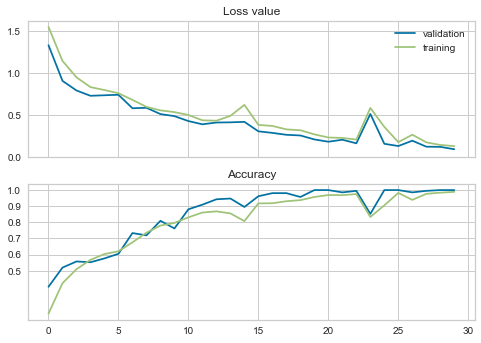

In [183]:
from matplotlib import pyplot as plt
plt.figure()
plt.subplot(211)
plt.plot(history.history['val_loss'], label="validation")
plt.plot(history.history['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(history.history['val_categorical_accuracy'],label="validation")
plt.plot(history.history['categorical_accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()


In [184]:
from sklearn.metrics import classification_report, confusion_matrix  
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test,axis=1)
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

7/7 [==============================] - 1s 34ms/step
[[50  0  0  0  0]
 [ 0 34  0  0  0]
 [ 0  0 44  0  0]
 [ 0  0  0 46  0]
 [ 0  0  0  0 36]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00        36

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



### Prediction time

In [185]:
import time
# start_time = time.time()
# print(np.expand_dims(X_test[0],axis=0).shape)
# print(X_test[0].shape)
# y_pred = model.predict(np.expand_dims(X_test[0],axis=0))
# print("--- %s seconds ---" % (time.time() - start_time))

times = []
minTime = float("inf")
maxTime = float("-inf")
for i in range(100):
    input = np.expand_dims(X_test[i],axis=0)
    start_time = time.time()
    model.predict(input)
    total_time = time.time() - start_time
    if total_time > maxTime:
        maxTime = total_time
    if total_time < minTime:
        minTime=total_time
    times.append(total_time)

print("--- Average prediction time in 100 samples : %sms, min: %sms, max: %sms ---" % (int(np.average(times) * 1000),int(minTime * 1000),int(maxTime * 1000)))



1/1 [==============================] - 0s 35ms/step
--- Average prediction time in 100 samples : 85ms, min: 71ms, max: 226ms ---


In [186]:
y_pred = model.predict(X_test)
y_pred

7/7 [==============================] - 0s 45ms/step


array([[1.57824531e-01, 1.50229444e-03, 8.19186091e-01, 1.43900439e-02,
        7.09709479e-03],
       [1.25656230e-03, 1.20561235e-01, 1.43559696e-02, 8.25449824e-01,
        3.83764207e-02],
       [2.24670907e-17, 9.99908686e-01, 7.55007981e-13, 8.91218515e-05,
        2.17597403e-06],
       ...,
       [9.07270886e-18, 1.88234765e-07, 2.44330770e-14, 1.62201041e-09,
        9.99999762e-01],
       [9.98842835e-01, 3.47244643e-23, 1.15710811e-03, 7.57909002e-21,
        2.46509314e-18],
       [1.77208528e-01, 8.35513347e-04, 8.08972955e-01, 8.47077835e-03,
        4.51216800e-03]], dtype=float32)

### try larger dropout

In [25]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.5,
    dropout=0.5,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
    validation_data=(X_test, Y_test)
)

model.evaluate(X_test, Y_test, verbose=1)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 30, 258)]    0           []                               
                                                                                                  
 layer_normalization_40 (LayerN  (None, 30, 258)     516         ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_20 (Multi  (None, 30, 258)     1060098     ['layer_normalization_40[0][0]', 
 HeadAttention)                                                   'layer_normalization_40[0][0]'] 
                                                                                            

[0.5256912708282471, 0.6666666865348816]

### try different learning rate

In [24]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.1,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=20,
    callbacks=callbacks,
    validation_data=(X_test, Y_test)
)

model.evaluate(X_test, Y_test, verbose=1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30, 258)]    0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 30, 258)     516         ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 30, 258)     1060098     ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

[0.08212970197200775, 0.9666666388511658]

### Save Model

In [128]:
model.save("../models_output/transformer.h5")

In [34]:
model.save_weights("../models_output/transformer_weight.h5")

In [14]:
threshold = 0.5
frames = []


cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hoslistic:
    while cap.isOpened():
        success, frame = cap.read()
        if not success: # if capture frame failed then skip the logic below and retry
            continue

        # Copy frame
        img = frame.copy()
        img = cv2.cvtColor(cv2.flip(img,1),cv2.COLOR_BGR2RGB) # Set frame color to RGB to process
        # img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        # input_img = tf.cast(img, dtype=tf.int32)
        img.flags.writeable = False
        # Detection section
        results = hoslistic.process(img)
        img.flags.writeable = True
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) # set back to original color
        # draw keypoints to the frame
        mp_drawing.draw_landmarks(img,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(img,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
        mp_drawing.draw_landmarks(img,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
        keypoints = keypointsToNumPy(results)
        frames.append(keypoints)
        # just get last 30 frames
        frames = frames[-15:]
        if len(frames) == 15:
            a = np.array(frames)
            # convert it to proper input (1,30,258)
            print(np.expand_dims(frames,axis=0).shape)
            # get the first prediction as we only pass one into it
            r = model.predict(np.expand_dims(frames,axis=0))[0]

            print(actions[np.argmax(r)])
            cv2.putText(img,f'Action {actions[np.argmax(r)]}',(20,70),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2,cv2.LINE_AA,False)
        cv2.imshow('Testing Final Model', img)
         #This breaks on 'q' key
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
print("HERE")
cap.release()
cv2.destroyAllWindows()

(1, 15, 258)
1/1 [==============================] - 0s 339ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 33ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 33ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 28ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 28ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 30ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 31ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 29ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 28ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 37ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 30ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 31ms/step
Right_punch
(1, 15, 258)
1/1 [==============================] - 0s 32ms/step
Right_punc

In [16]:
#!/usr/bin/env python

import asyncio
import websockets
import json
from attrdict import AttrDict


async def echo(websocket):
    frames = []
    async for message in websocket:
        # print(message)
        try:
            y = json.loads(message)
            results = AttrDict({
                "pose_landmarks":{
                    "landmark":[]
                },
                "left_hand_landmarks":{
                    "landmark":[]
                },
                "right_hand_landmarks":{
                    "landmark":[]
                }
            })
            results["pose_landmarks"]["landmark"] = y["poseLandmarks"]
            if "leftHandLandmarks" in y:
                results["left_hand_landmarks"]["landmark"] = y["leftHandLandmarks"]
            if "rightHandLandmarks" in y:
                results["right_hand_landmarks"]["landmark"] = y["rightHandLandmarks"]
            keypoints = keypointsToNumPy(results)
            frames.append(keypoints)
            # just get last 30 frames
            frames = frames[-30:]
            if len(frames) == 30:
                a = np.array(frames)
                # convert it to proper input (1,30,258)
                print(np.expand_dims(frames,axis=0).shape)
                # get the first prediction as we only pass one into it
                r = model.predict(np.expand_dims(frames,axis=0))[0]
                r[r<0.5] = 0
                print(actions[np.argmax(r)])
                await websocket.send(actions[np.argmax(r)] + "," + str(r))
        except Exception as e:
            print(e)
        # await websocket.send(message + "server")

async def main():
    async with websockets.serve(echo, "localhost", 8765):
        await asyncio.Future()  # run forever

await main()

: 

In [4]:
model = keras.models.load_model('transformer.h5')
frames = []


2022-10-22 16:42:53.703028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
from attrdict import AttrDict
j = {
    "image": {},
    "poseLandmarks": [
        {
            "x": 0.5880926847457886,
            "y": 0.25798192620277405,
            "z": -0.3409603238105774,
            "visibility": 0.8919544816017151
        },
        {
            "x": 0.5906530618667603,
            "y": 0.21301409602165222,
            "z": -0.3438095450401306,
            "visibility": 0.8915821313858032
        },
        {
            "x": 0.5938440561294556,
            "y": 0.2152775377035141,
            "z": -0.3432357907295227,
            "visibility": 0.8881502747535706
        },
        {
            "x": 0.5961824655532837,
            "y": 0.24234987795352936,
            "z": -0.34266433119773865,
            "visibility": 0.8926075100898743
        },
        {
            "x": 0.5731982588768005,
            "y": 0.21209882199764252,
            "z": -0.352565199136734,
            "visibility": 0.898253858089447
        },
        {
            "x": 0.5733095407485962,
            "y": 0.21431241929531097,
            "z": -0.3517971634864807,
            "visibility": 0.8994075059890747
        },
        {
            "x": 0.5739877820014954,
            "y": 0.2128763347864151,
            "z": -0.3512287139892578,
            "visibility": 0.9117918014526367
        },
        {
            "x": 0.5697293877601624,
            "y": 0.2675153315067291,
            "z": -0.25576305389404297,
            "visibility": 0.9092066884040833
        },
        {
            "x": 0.5450958013534546,
            "y": 0.2680749297142029,
            "z": -0.2955373525619507,
            "visibility": 0.9304062724113464
        },
        {
            "x": 0.5863133668899536,
            "y": 0.3318489193916321,
            "z": -0.2829187214374542,
            "visibility": 0.9342498779296875
        },
        {
            "x": 0.5599755644798279,
            "y": 0.3260250389575958,
            "z": -0.2969871461391449,
            "visibility": 0.9371410608291626
        },
        {
            "x": 0.5801748037338257,
            "y": 0.5935178399085999,
            "z": -0.2736220061779022,
            "visibility": 0.912200927734375
        },
        {
            "x": 0.4459652304649353,
            "y": 0.5696370005607605,
            "z": -0.21251575648784637,
            "visibility": 0.9175193309783936
        },
        {
            "x": 0.6751126050949097,
            "y": 0.4636211097240448,
            "z": -0.25243455171585083,
            "visibility": 0.2201475352048874
        },
        {
            "x": 0.5622193217277527,
            "y": 0.37807875871658325,
            "z": -0.31541818380355835,
            "visibility": 0.5996300578117371
        },
        {
            "x": 0.6549735069274902,
            "y": 0.34549733996391296,
            "z": -0.2163480520248413,
            "visibility": 0.0974506288766861
        },
        {
            "x": 0.6559590101242065,
            "y": 0.20786024630069733,
            "z": -0.30346372723579407,
            "visibility": 0.5821789503097534
        },
        {
            "x": 0.6463615894317627,
            "y": 0.321217805147171,
            "z": -0.2780008912086487,
            "visibility": 0.11436416208744049
        },
        {
            "x": 0.693077027797699,
            "y": 0.187992662191391,
            "z": -0.36558860540390015,
            "visibility": 0.48644331097602844
        },
        {
            "x": 0.6419552564620972,
            "y": 0.30604445934295654,
            "z": -0.2915250062942505,
            "visibility": 0.15957696735858917
        },
        {
            "x": 0.6841744780540466,
            "y": 0.1734585165977478,
            "z": -0.39454224705696106,
            "visibility": 0.5455245971679688
        },
        {
            "x": 0.6478661298751831,
            "y": 0.315883606672287,
            "z": -0.22825300693511963,
            "visibility": 0.1651751548051834
        },
        {
            "x": 0.6640509963035583,
            "y": 0.1808464080095291,
            "z": -0.3227384090423584,
            "visibility": 0.5639793276786804
        },
        {
            "x": 0.5123761892318726,
            "y": 1.687013030052185,
            "z": -0.1400032490491867,
            "visibility": 0.004396136850118637
        },
        {
            "x": 0.4314190447330475,
            "y": 1.7275233268737793,
            "z": 0.14165827631950378,
            "visibility": 0.006525450386106968
        },
        {
            "x": 0.4721241593360901,
            "y": 1.0836482048034668,
            "z": -0.1921553760766983,
            "visibility": 0.0274144746363163
        },
        {
            "x": 0.3245542645454407,
            "y": 1.0569993257522583,
            "z": 0.08145172894001007,
            "visibility": 0.01599154807627201
        },
        {
            "x": 0.42380523681640625,
            "y": 1.2012594938278198,
            "z": 0.5203500986099243,
            "visibility": 0.012692037038505077
        },
        {
            "x": 0.39563223719596863,
            "y": 1.0644021034240723,
            "z": 0.5947502851486206,
            "visibility": 0.013977599330246449
        },
        {
            "x": 0.4009716510772705,
            "y": 1.2437248229980469,
            "z": 0.5071300864219666,
            "visibility": 0.009529875591397285
        },
        {
            "x": 0.39320793747901917,
            "y": 1.079322338104248,
            "z": 0.636406660079956,
            "visibility": 0.015066493302583694
        },
        {
            "x": 0.41117534041404724,
            "y": 1.1338329315185547,
            "z": 0.16041305661201477,
            "visibility": 0.015477227047085762
        },
        {
            "x": 0.39750704169273376,
            "y": 0.9203481078147888,
            "z": 0.44569554924964905,
            "visibility": 0.01837105117738247
        }
    ],
    "ea": [
        {
            "x": 0.09289216995239258,
            "y": -0.6210291385650635,
            "z": -0.08330655843019485,
            "visibility": 0.8919544816017151
        },
        {
            "x": 0.09615056216716766,
            "y": -0.6476690769195557,
            "z": -0.08925311267375946,
            "visibility": 0.8915821313858032
        },
        {
            "x": 0.09625852853059769,
            "y": -0.6487014889717102,
            "z": -0.0880894586443901,
            "visibility": 0.8881502747535706
        },
        {
            "x": 0.09595300257205963,
            "y": -0.6482436656951904,
            "z": -0.0878986120223999,
            "visibility": 0.8926075100898743
        },
        {
            "x": 0.09477884322404861,
            "y": -0.6427960395812988,
            "z": -0.09030025452375412,
            "visibility": 0.898253858089447
        },
        {
            "x": 0.09505582600831985,
            "y": -0.6437684297561646,
            "z": -0.09140385687351227,
            "visibility": 0.8994075059890747
        },
        {
            "x": 0.09400612860918045,
            "y": -0.6452643275260925,
            "z": -0.09028586745262146,
            "visibility": 0.9117918014526367
        },
        {
            "x": 0.08206788450479507,
            "y": -0.6115298271179199,
            "z": -0.07315720617771149,
            "visibility": 0.9092066884040833
        },
        {
            "x": 0.06100695580244064,
            "y": -0.6052977442741394,
            "z": -0.09453994780778885,
            "visibility": 0.9304062724113464
        },
        {
            "x": 0.07747616618871689,
            "y": -0.5872812867164612,
            "z": -0.07611992210149765,
            "visibility": 0.9342498779296875
        },
        {
            "x": 0.07349167764186859,
            "y": -0.5837600231170654,
            "z": -0.08128707855939865,
            "visibility": 0.9371410608291626
        },
        {
            "x": 0.08297406882047653,
            "y": -0.46915847063064575,
            "z": -0.0627308264374733,
            "visibility": 0.912200927734375
        },
        {
            "x": 0.00892446469515562,
            "y": -0.4793561100959778,
            "z": -0.07702311128377914,
            "visibility": 0.9175193309783936
        },
        {
            "x": 0.13862808048725128,
            "y": -0.5210443139076233,
            "z": -0.054063647985458374,
            "visibility": 0.2201475352048874
        },
        {
            "x": 0.09095865488052368,
            "y": -0.5571553707122803,
            "z": -0.08537811040878296,
            "visibility": 0.5996300578117371
        },
        {
            "x": 0.15426330268383026,
            "y": -0.5839791297912598,
            "z": -0.0596354715526104,
            "visibility": 0.0974506288766861
        },
        {
            "x": 0.14378727972507477,
            "y": -0.6427748799324036,
            "z": -0.07257787883281708,
            "visibility": 0.5821789503097534
        },
        {
            "x": 0.14889346063137054,
            "y": -0.5860608220100403,
            "z": -0.07307718694210052,
            "visibility": 0.11436416208744049
        },
        {
            "x": 0.16449372470378876,
            "y": -0.6411864757537842,
            "z": -0.08661572635173798,
            "visibility": 0.48644331097602844
        },
        {
            "x": 0.15136556327342987,
            "y": -0.5933023691177368,
            "z": -0.08239606767892838,
            "visibility": 0.15957696735858917
        },
        {
            "x": 0.1588146835565567,
            "y": -0.644176185131073,
            "z": -0.09475967288017273,
            "visibility": 0.5455245971679688
        },
        {
            "x": 0.1556403785943985,
            "y": -0.5849223136901855,
            "z": -0.06097546964883804,
            "visibility": 0.1651751548051834
        },
        {
            "x": 0.14925134181976318,
            "y": -0.6400735974311829,
            "z": -0.07864373177289963,
            "visibility": 0.5639793276786804
        },
        {
            "x": 0.04173381254076958,
            "y": -0.0029893391765654087,
            "z": -0.013512257486581802,
            "visibility": 0.004396136850118637
        },
        {
            "x": -0.041134659200906754,
            "y": -0.007254003081470728,
            "z": 0.014719926752150059,
            "visibility": 0.006525450386106968
        },
        {
            "x": -0.011308733373880386,
            "y": -0.29514214396476746,
            "z": -0.033202581107616425,
            "visibility": 0.0274144746363163
        },
        {
            "x": -0.09258024394512177,
            "y": -0.34360286593437195,
            "z": 0.027876390144228935,
            "visibility": 0.01599154807627201
        },
        {
            "x": 0.038051538169384,
            "y": -0.3262351453304291,
            "z": 0.1751028597354889,
            "visibility": 0.012692037038505077
        },
        {
            "x": -0.021609315648674965,
            "y": -0.36210429668426514,
            "z": 0.18663333356380463,
            "visibility": 0.013977599330246449
        },
        {
            "x": 0.03930986672639847,
            "y": -0.3227757513523102,
            "z": 0.19526518881320953,
            "visibility": 0.009529875591397285
        },
        {
            "x": -0.030160173773765564,
            "y": -0.3622894287109375,
            "z": 0.20780430734157562,
            "visibility": 0.015066493302583694
        },
        {
            "x": 0.016622375696897507,
            "y": -0.4049746096134186,
            "z": 0.05837491527199745,
            "visibility": 0.015477227047085762
        },
        {
            "x": -0.04433808475732803,
            "y": -0.44549357891082764,
            "z": 0.10847770422697067,
            "visibility": 0.01837105117738247
        }
    ],
    "segmentationMask": {},
    "multiFaceGeometry": []
}

pyjson = AttrDict({
    "pose_landmarks":{
        "landmark":[]
    },
    "left_hand_landmarks":{
        "landmark":[]
    },
    "right_hand_landmarks":{
        "landmark":[]
    }
})

pyjson["pose_landmarks"]["landmark"] = j["poseLandmarks"]
if "leftHandLandmarks" in j:
    pyjson["left_hand_landmarks"]["landmark"] = j["leftHandLandmarks"]
if "rightHandLandmarks" in j:
    pyjson["right_hand_landmarks"]["landmark"] = j["rightHandLandmarks"]


print(keypointsToNumPy(pyjson).shape)

(258,)
